In [32]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [17]:
#Objectif : préparer des données pour décrire l'évolution dans le temps de données de température maximale à différents 
#endroits (les stations)

In [18]:
#Fichier de départ ; fichier global issu de l'opération de concaténation des fichiers sources
# et de la sélection d'une part des variables , d'autre part des stations

data_Synop=pd.read_csv(r"C:\DATA\meteo\data_synop.csv")
data_Synop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3248258 entries, 0 to 3248257
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ID_station      int64  
 1   date            int64  
 2   t               object 
 3   Nom_station     object 
 4   Latitude        float64
 5   Longitude       float64
 6   Altitude        int64  
 7   geometry        object 
 8   distance_Paris  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 223.0+ MB


In [19]:
#Traitement des valeurs manquantes de la variable t
#Principe : on remplace la valeur manquante par la valeur de la ligne précédente
#Rq : nous disposons d'une valeur de température toutes les 3 heures à 0h,3h,6h,9h,12h,15h,18h et 21 h 
traités=0
for j in np.arange(data_Synop.shape[0]):
    val=data_Synop.iloc[j,2]
    if val=="mq":
        traités+=1
        data_Synop.iloc[j,2]=data_Synop.iloc[j-1,2]
        
taux_traités=traités/data_Synop.shape[0]*100 


print("Nombre de valeurs traitées t traitées: ",traités," soit " ,taux_traités," % " ," des lignes")



Nombre de valeurs traitées t traitées:  12101  soit  0.3725381419825642  %   des lignes


In [20]:
#Traitement des types de variables
data_Synop=data_Synop.astype({"ID_station":"str","date":"str","t":"float"})

#Traitement de la date et ajout de variables temporelles
data_Synop["Date_jour"]=data_Synop["date"].apply(lambda x: x[0:8])
data_Synop["Année"]=data_Synop["Date_jour"].apply(lambda x: x[0:4])
data_Synop["Heure"]=data_Synop["date"].apply(lambda x: x[8:10]).astype("int64")
data_Synop["Date_jour"]=pd.to_datetime(data_Synop["Date_jour"])
data_Synop["Numéro_mois"]=data_Synop["Date_jour"].dt.month
data_Synop["Mois"]=data_Synop["Date_jour"].dt.month_name(locale="French")

#Ajout d'une variable temporaire "ID_station-date"
data_Synop["ID_station-date"]=data_Synop["ID_station"]+"-"+data_Synop["date"].apply(lambda x: x[0:8])

#On enlève la colonne date qui n'est plus utile 
data_Synop=data_Synop.drop("date",axis=1)

In [21]:
#Calcul de la température maximale par jour et station .
#On l'ajoute ensuite au fichier préalablement filtré sur 12h pour ne conserver qu'une ligne par jour et station

data_tempmax=data_Synop.groupby(["ID_station-date"],as_index=False).agg({"t":"max"})
data_tempmax=data_tempmax.rename({"t":"Température_max"},axis=1)

data_meteo=data_Synop[data_Synop["Heure"]==12]
data_meteo=data_meteo.merge(right=data_tempmax,on="ID_station-date",how="inner")
data_meteo=data_meteo.rename({"Nom_station":"Station"},axis=1)
#On enlève les colonnes qui ne servent plus
data_meteo=data_meteo.drop(["ID_station-date","Heure","t"],axis=1)
data_meteo=data_meteo.reset_index(drop=True)

#Nombre de lignes après traitement
print("Nombre de lignes de data_meteo :",data_meteo.shape[0])

#On s'attend à 3248258/8= 406000 environ..


Nombre de lignes de data_meteo : 406842


In [22]:
#Transformations suivantes

#Transformation de l'année en entier
data_meteo["Année"]=data_meteo["Année"].astype("int64")

#Transformation des températures de K à °C
data_meteo["Température_max"]=data_meteo["Température_max"]-273.15

#Décision d'enlever la colonne géométrie (on reprendra plus tard directement les informations dans la liste des stations)
data_meteo=data_meteo.drop(["geometry"],axis=1)

#Décision d'éliminer l'année 2023 pour avoir des années complètes 
data_meteo=data_meteo[data_meteo["Année"]!=2023]

#Vérification que l'on a des données tous les ans pour toutes les stations
test_année=data_meteo.groupby(["ID_station","Année"],as_index=False).agg({"Date_jour":"count"})

test_année_2=test_année.groupby(["ID_station"],as_index=False).agg({"Année":"count"})
test_année_2=test_année_2.sort_values(by="Année")
print("Nombre d'années avec des relevés , par station (on attend 27):")
print(test_année_2.head(10))

#Décision d'éliminer la station 7072 qui ne dispose que de 11 années de mesures
data_meteo=data_meteo[data_meteo["ID_station"]!="7072"]

Nombre d'années avec des relevés , par station (on attend 27):
   ID_station  Année
5        7072     11
0        7005     27
23       7460     27
24       7471     27
25       7481     27
26       7510     27
27       7535     27
28       7558     27
29       7577     27
30       7591     27


Limites outliers:

limite inf: -5.0
limite sup: 38.2


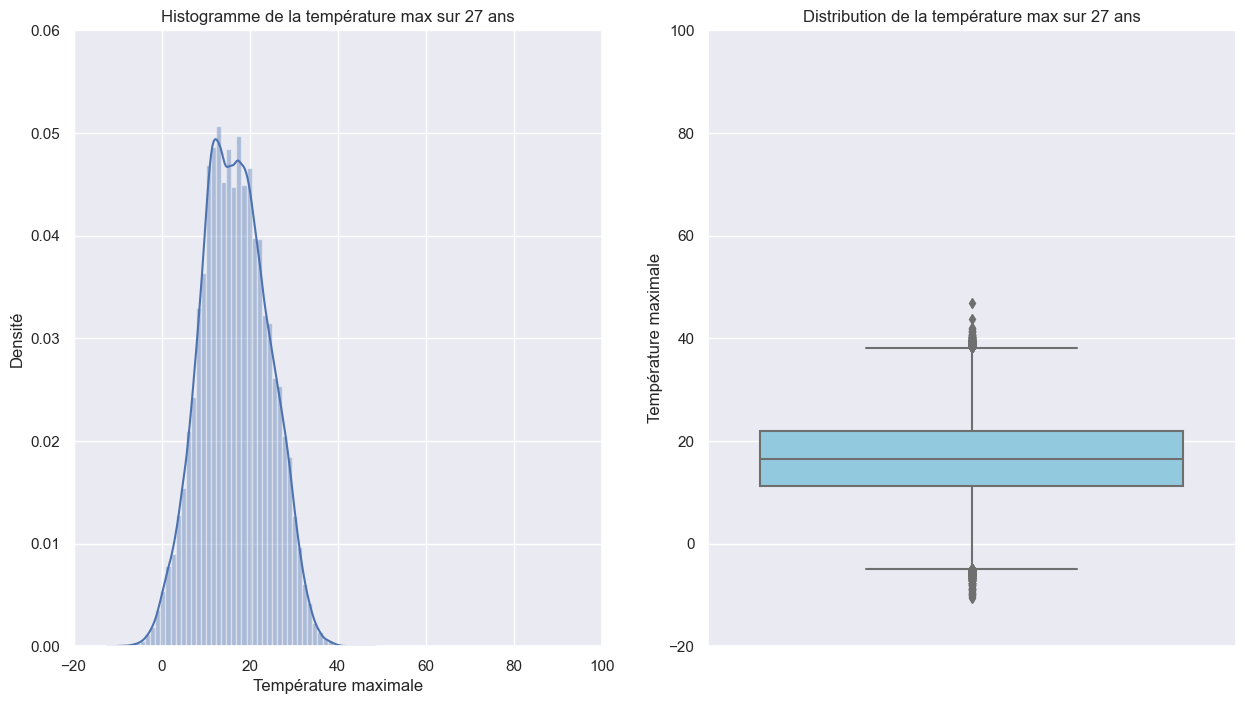

In [39]:
#Distribution de la variable 'température max' , vérification des outliers

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.distplot(ax=axes[0],a=data_meteo["Température_max"],kde=True, hist=True )
axes[0].set_title("Histogramme de la température maximale sur 27 ans")
axes[0].set(xlim=[-20,100],ylim=[0,0.06])
axes[0].set_xlabel("Température maximale")
axes[0].set_ylabel("Densité")
sns.boxplot(ax=axes[1],y="Température_max",data=data_meteo,palette=["#87CEEB"])
axes[1].set_title("Distribution de la température maximale sur 27 ans")
axes[1].set_ylabel("Température maximale")
axes[1].set_ylim([-20,100])

#Calcul des limites outliers
Q1=np.quantile(data_meteo["Température_max"],0.25)
Q3=np.quantile(data_meteo["Température_max"],0.75)
lim_inf=Q1-1.5*(Q3-Q1)
lim_sup=Q3+1.5*(Q3-Q1)
    
print("Limites outliers:\n") 
print("limite inf:",lim_inf.round(3))
print("limite sup:",lim_sup.round(3))

In [24]:
#Décision de filtrer les températures max supérieures ou égales à 60°C, soit 2 valeurs
#On est prudent avec les valeurs autour de 40°C , et on les conserve

data_meteo_exclues=data_meteo[data_meteo["Température_max"]>60]
data_meteo_exclues=data_meteo_exclues[["Station","Date_jour","Température_max"]]
print("Données à exclure :\n",data_meteo_exclues)

#Les 2 valeurs exclues concernent le 1er trimestre de 1996 

#Filtrage
data_meteo=data_meteo[data_meteo["Température_max"]<=60]

#Ajout d'une colonne de comptage des jours où la température dépasse 30°C

data_meteo["Jours>30°C"]=data_meteo["Température_max"].apply(lambda x :1 if x>30 else 0)

Données à exclure :
                   Station  Date_jour  Température_max
62977         PLOUMANAC'H 1996-01-07             96.0
239889  BORDEAUX-MERIGNAC 1996-03-09             60.8


In [25]:
#Vérification Quel est le nombre de dates et y-a-t-il des trous dans le calendrier ?
#Ce sont les valeurs uniques de la variables date_I à comparer à l'intervalle entre les dates min et max

liste_dates=np.unique(data_meteo["Date_jour"],return_counts=True)
df_dates=pd.DataFrame({"date":liste_dates[0],
                          "occurence":liste_dates[1]})
nbdates=df_dates.shape[0]
print("Nombre de dates:",nbdates)

nbjours=(df_dates["date"].max()-df_dates["date"].min()).days+1

print("Intervalle couvert en nombre de jours :",nbjours)

if nbjours==nbdates:
    print("Il n' y a pas de trou dans le calendrier")
else:
    print("Il y a des trous dans le calendrier")
    print("Nombre de dates manquantes :",nbjours-nbdates)
    
print("date minimale :",df_dates["date"].min())
# Remarque 2 il manque 5 j sur toute la période depuis le 1 janvier 1996

Nombre de dates: 9857
Intervalle couvert en nombre de jours : 9862
Il y a des trous dans le calendrier
Nombre de dates manquantes : 5
date minimale : 1996-01-01 00:00:00


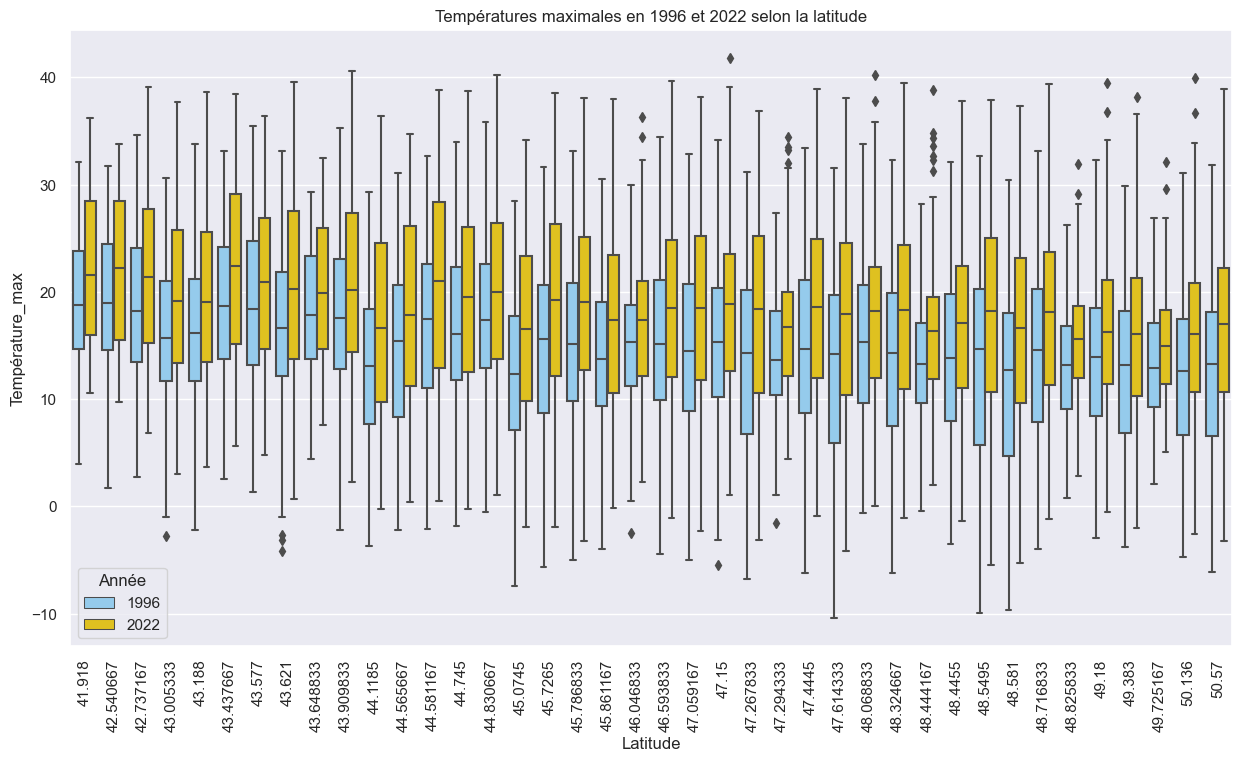

In [36]:
#Correction apportée rétroactivement après le début de l'analyse

#Représentation de temp_max an fonction de la latitude
# 2 années : 1996 ,2022
deux_années=list([1996,2022])
df=data_meteo[data_meteo["Année"].isin(deux_années)]
plt.figure(figsize=(15,8))
sns.boxplot(x="Latitude",y="Température_max",data=df,hue="Année",palette=["lightskyblue","gold"])
plt.title("Températures maximales en 1996 et 2022 selon la latitude")
plt.xticks(rotation=90)
plt.ylabel("Température maximale");

#On note un problème à la latitude 43.079333 : il n'y a pas de box mais une valeur constante pour l'année 2022

In [37]:
#Vérification de la station correspondante avec la variance sur les années 

test=data_meteo[data_meteo["Latitude"]==43.079333]
test=test.groupby(["Année"],as_index=False).agg({"Température_max":"var"})

sns.catplot(x="Année",y="Température_max",data=test,kind="bar",aspect=1.5,color="skyblue")
plt.ylim([0,60])
plt.title("Variance de la température max à la station de latitude 43.079333 au cours des années")
plt.xticks(rotation=90);

#Effectivement la variance de la variable temp_max devient nulle à partir de 2020 pour la station de 
#latitude 43.079333


ValueError: min() arg is an empty sequence

In [28]:
data_meteo[data_meteo["Latitude"]==43.079333]

,ID_station,Station,Latitude,Longitude,Altitude,distance_Paris,Date_jour,Année,Numéro_mois,Mois,Température_max,Jours>30°C
347972,7661,CAP CEPET,43.079333,5.940833,115,699.906,1996-01-01,1996,1,Janvier,12.80,0
347973,7661,CAP CEPET,43.079333,5.940833,115,699.906,1996-01-02,1996,1,Janvier,12.60,0
347974,7661,CAP CEPET,43.079333,5.940833,115,699.906,1996-01-03,1996,1,Janvier,11.80,0
347975,7661,CAP CEPET,43.079333,5.940833,115,699.906,1996-01-04,1996,1,Janvier,11.60,0
347976,7661,CAP CEPET,43.079333,5.940833,115,699.906,1996-01-05,1996,1,Janvier,9.39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
357545,7661,CAP CEPET,43.079333,5.940833,115,699.906,2022-12-27,2022,12,Décembre,10.90,0
357546,7661,CAP CEPET,43.079333,5.940833,115,699.906,2022-12-28,2022,12,Décembre,10.90,0
357547,7661,CAP CEPET,43.079333,5.940833,115,699.906,2022-12-29,2022,12,Décembre,10.90,0
357548,7661,CAP CEPET,43.079333,5.940833,115,699.906,2022-12-30,2022,12,Décembre,10.90,0


In [29]:
#Décision d'exclure du fichier les données de la station situées à cette latitude :

data_meteo=data_meteo[data_meteo["Latitude"]!=43.079333]

#Les nouvelles caractéristiques de la base sont :
liste_stations=list(data_meteo["ID_station"].unique())
print("Le nombre de stations conservées:",len(liste_stations))
print("Nombre de lignes du du fichier data_meteo:",data_meteo.shape[0])

Le nombre de stations conservées: 40
Nombre de lignes du du fichier data_meteo: 391723


In [30]:
#Export du fichier pour l'analyse finale
data_meteo.to_csv(r"C:\DATA\meteo\data_meteo_traité.csv",index=False)